In [ ]:
!pip install dgl
!pip install jenkspy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd

y_traffic_volume=pd.read_csv('/content/number-synvalues.csv')
features=pd.read_csv('/content/Full_road_values.csv')

edge = pd.read_csv('/content/Road_network.csv')

In [ ]:
from jenkspy import JenksNaturalBreaks

jnb =JenksNaturalBreaks(5)
jnb.fit(list(y_traffic_volume['count'].values))
data_label_norm = jnb.labels_

len(data_label_norm)

5075

In [ ]:
data_label_norm[1182]

1

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
# device = torch.device('cuda:0')

import numpy as np
from dgl.data import DGLDataset
import dgl


class MyDataset(DGLDataset):
    '''
    自定义数据集
    '''
    def __init__(self):
        super().__init__(name='synthetic')
    def process(self):
        nodes_data = pd.read_csv('/content/Full_road_values.csv')
        edges_data = pd.read_csv('/content/Road_network.csv')
        node_features = torch.from_numpy(nodes_data.iloc[:,1:].to_numpy())
        node_labels = torch.from_numpy(np.array(data_label_norm))

        edge_features = torch.from_numpy(edges_data['Weights'].to_numpy())
        edge_features=edge_features.to(torch.float32)
        print(edge_features)

        edges_src = torch.from_numpy(edge['RoadID'].astype('category').cat.codes.to_numpy())
        edges_src=edges_src.to(torch.int32)
        # print(edges_src)
        edges_dst = torch.from_numpy(edge['RoadID_2'].astype('category').cat.codes.to_numpy())
        edges_dst=edges_dst.to(torch.int32)


        # edges_src = torch.from_numpy(edge['RoadID'].to_numpy())
        # edges_dst = torch.from_numpy(edge['RoadID_2'].to_numpy())

        self.graph = dgl.graph((edges_src, edges_dst), num_nodes=nodes_data.shape[0],idtype=torch.int32)
        self.graph.ndata['feat'] = node_features
        self.graph.ndata['label'] = node_labels

        self.graph.edata['weight'] = edge_features

        # If your dataset is a node classification dataset, you will need to assign
        # masks indicating whether a node belongs to training, validation, and test set.
        n_nodes = nodes_data.shape[0]
        n_train = int(n_nodes * 0.2)
        n_val = int(n_nodes * 0.1)
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        val_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[:n_train] = True
        val_mask[n_train:n_train + n_val] = True
        test_mask[n_train + n_val:] = True
        self.graph.ndata['train_mask'] = train_mask
        self.graph.ndata['val_mask'] = val_mask
        self.graph.ndata['test_mask'] = test_mask

    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

In [ ]:
dataset = MyDataset()

g = dataset[0]


tensor([1., 1., 1.,  ..., 1., 1., 1.])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)


In [ ]:
g

Graph(num_nodes=5075, num_edges=24338,
      ndata_schemes={'feat': Scheme(shape=(19,), dtype=torch.float64), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float32)})

In [ ]:
g.ndata['feat'].double()

tensor([[3.6908e-01, 8.5239e-03, 5.5676e-02,  ..., 0.0000e+00, 3.3531e-03,
         6.0177e-04],
        [3.1348e-01, 6.7110e-03, 1.6385e-01,  ..., 0.0000e+00, 9.2506e-04,
         1.2800e-05],
        [3.4598e-01, 8.9353e-03, 6.5192e-02,  ..., 4.7700e-07, 8.6800e-05,
         1.1900e-05],
        ...,
        [3.0759e-01, 2.0184e-02, 2.0113e-01,  ..., 0.0000e+00, 3.8370e-04,
         2.9440e-03],
        [2.3477e-01, 1.0309e-02, 3.8267e-01,  ..., 0.0000e+00, 6.7744e-03,
         2.0576e-03],
        [2.0135e-01, 2.0895e-03, 5.8558e-02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], dtype=torch.float64)

In [ ]:
# Define a model
# import dgl
import dgl.function as fn
import torch
import torch.nn as nn
# from dgl.data import CoraGraphDataset
from dgl.nn import GNNExplainer
import torch.nn.functional as F

from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, graph, feat, eweight=None):


        with graph.local_scope():
            h = self.conv1(graph, feat)
            h = F.relu(h)
            h = self.conv2(graph, h)
            # feat = self.linear(feat)
            graph.ndata['h'] = h
            if eweight is None:
                graph.update_all(fn.copy_u('h', 'm'), fn.sum('m', 'h'))
            else:
                graph.edata['w'] = eweight
                graph.update_all(fn.u_mul_e('h', 'w', 'm'), fn.sum('m', 'h'))
            return graph.ndata['h']


In [ ]:
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata['feat'].float()
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    for e in range(1000):
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))
model = GCN(g.ndata['feat'].shape[1], 16, 7)
train(g, model)

In epoch 0, loss: 1.934, val acc: 0.002 (best 0.002), test acc: 0.001 (best 0.001)


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In epoch 5, loss: 0.941, val acc: 0.850 (best 0.850), test acc: 0.812 (best 0.812)
In epoch 10, loss: 0.775, val acc: 0.850 (best 0.850), test acc: 0.812 (best 0.812)
In epoch 15, loss: 0.708, val acc: 0.850 (best 0.850), test acc: 0.812 (best 0.812)
In epoch 20, loss: 0.647, val acc: 0.850 (best 0.850), test acc: 0.812 (best 0.812)
In epoch 25, loss: 0.642, val acc: 0.850 (best 0.850), test acc: 0.812 (best 0.812)
In epoch 30, loss: 0.618, val acc: 0.850 (best 0.850), test acc: 0.812 (best 0.812)
In epoch 35, loss: 0.609, val acc: 0.850 (best 0.850), test acc: 0.812 (best 0.812)
In epoch 40, loss: 0.597, val acc: 0.850 (best 0.850), test acc: 0.812 (best 0.812)
In epoch 45, loss: 0.586, val acc: 0.850 (best 0.850), test acc: 0.812 (best 0.812)
In epoch 50, loss: 0.576, val acc: 0.850 (best 0.850), test acc: 0.812 (best 0.812)
In epoch 55, loss: 0.565, val acc: 0.850 (best 0.850), test acc: 0.812 (best 0.812)
In epoch 60, loss: 0.555, val acc: 0.850 (best 0.850), test acc: 0.812 (best 

In [ ]:
# class Model(nn.Module):
#     def __init__(self, in_feats, out_feats):
#         super(Model, self).__init__()
#         self.linear = nn.Linear(in_feats, out_feats)
#     def forward(self, graph, feat, eweight=None):
#         with graph.local_scope():
#             feat = self.linear(feat)
#             graph.ndata['h'] = feat
#             if eweight is None:
#                 graph.update_all(fn.copy_u('h', 'm'), fn.sum('m', 'h'))
#             else:
#                 graph.edata['w'] = eweight
#                 graph.update_all(fn.u_mul_e('h', 'w', 'm'), fn.sum('m', 'h'))
#             return graph.ndata['h']

In [ ]:
# g = data[0]
# features = g.ndata['feat'].float()
# labels = g.ndata['label']
# train_mask = g.ndata['train_mask']

# model2 = Model(features.shape[1], 3)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
# for epoch in range(100):
#     logits = model2(g, features)
#     loss = criterion(logits[train_mask], labels[train_mask])

#     pred = logits.argmax(1)
#     train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
#     print('In epoch {}, acc: {}'.format(epoch, train_acc))

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

In [ ]:
# from dgl.nn import GNNExplainer

explainer = GNNExplainer(model, num_hops=1)
features_catch = g.ndata['feat'].float()
new_center, sg, feat_mask, edge_mask = explainer.explain_node(4186, g, features_catch)
print(new_center)
print(sg.num_edges())
# Old IDs of the nodes in the subgraph
print(sg.ndata[dgl.NID])
# Old IDs of the edges in the subgraph
print(sg.edata[dgl.EID])
print("Nodes' importance:",feat_mask)
print("Edges importance:",edge_mask)

Explain node {node_id}: 100%|██████████| 100/100 [00:01<00:00, 76.16it/s]


tensor([14])
44
tensor([ 721, 1182, 1539, 1567, 1622, 1631, 1637, 1756, 1757, 3055, 3847, 3881,
        4170, 4171, 4186, 4847], dtype=torch.int32)
tensor([ 3385,  3386,  5646,  5648,  5649,  7438,  7566,  7568,  7816,  7817,
         7856,  7857,  7887,  8441,  8443,  8445, 14760, 14763, 14764, 18680,
        18683, 18845, 18848, 20203, 20204, 20205, 20209, 20277, 20278, 20279,
        20280, 20281, 20282, 20283, 20284, 20285, 20286, 20287, 20288, 20289,
        20290, 20291, 23450, 23451], dtype=torch.int32)
Nodes' importance: tensor([0.6822, 0.3610, 0.6990, 0.7032, 0.6793, 0.3336, 0.3067, 0.6265, 0.7170,
        0.3775, 0.6669, 0.7147, 0.6757, 0.6959, 0.7015, 0.6603, 0.2902, 0.7157,
        0.6781])
Edges importance: tensor([0.2197, 0.3383, 0.1658, 0.1931, 0.2953, 0.7611, 0.2077, 0.2200, 0.1879,
        0.3797, 0.3079, 0.8294, 0.7657, 0.8192, 0.1822, 0.2680, 0.2336, 0.8245,
        0.3793, 0.8298, 0.2813, 0.2045, 0.3187, 0.8301, 0.8265, 0.3106, 0.6371,
        0.1739, 0.1768, 0.1877

In [ ]:
sg

Graph(num_nodes=16, num_edges=44,
      ndata_schemes={'feat': Scheme(shape=(19,), dtype=torch.float64), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), '_ID': Scheme(shape=(), dtype=torch.int32)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int32)})

In [ ]:
nodes=[str(x) for x in sg.ndata[dgl.NID].tolist()]
edges=[str(x) for x in sg.edata[dgl.EID].tolist()]
nodes

['721',
 '1182',
 '1539',
 '1567',
 '1622',
 '1631',
 '1637',
 '1756',
 '1757',
 '3055',
 '3847',
 '3881',
 '4170',
 '4171',
 '4186',
 '4847']

(0, 11)
(3, 8)
(5, 15)
(6, 14)
(8, 3)
(14, 0)
(14, 1)
(14, 5)
(14, 6)
(14, 9)
(14, 12)
(14, 15)
(15, 5)


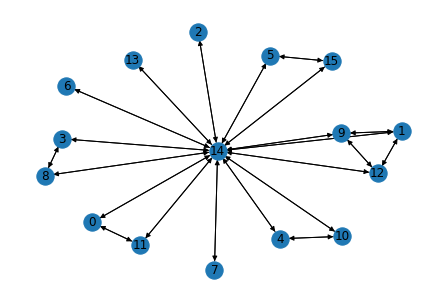

In [ ]:
import networkx as nx

G = dgl.to_networkx(sg)
list_edges=list(G.edges())
print(list_edges[0])
print(list_edges[6])
print(list_edges[11])
print(list_edges[12])
print(list_edges[14])
print(list_edges[27])
print(list_edges[28])
print(list_edges[32])
print(list_edges[33])
print(list_edges[36])
print(list_edges[39])
print(list_edges[41])
print(list_edges[42])
nx.draw(G,with_labels=True)